In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /home/z4hid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In [5]:
#Load the data

data = pd.read_csv(r"data.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [8]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [9]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [10]:
#We will drop the null record

data.dropna(inplace=True)

In [11]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [12]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [13]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [14]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


In [15]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [16]:
len(data)

3149

In [17]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


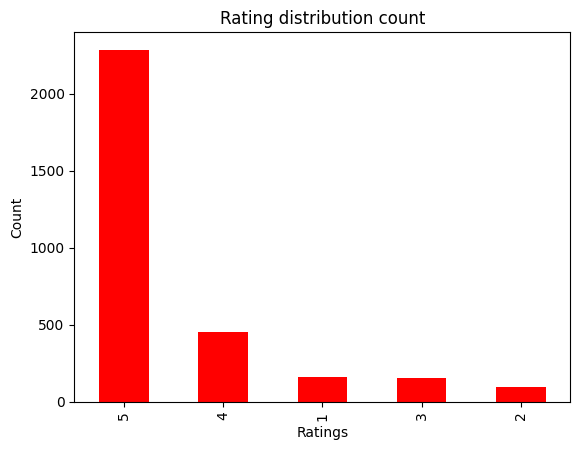

In [18]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [19]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


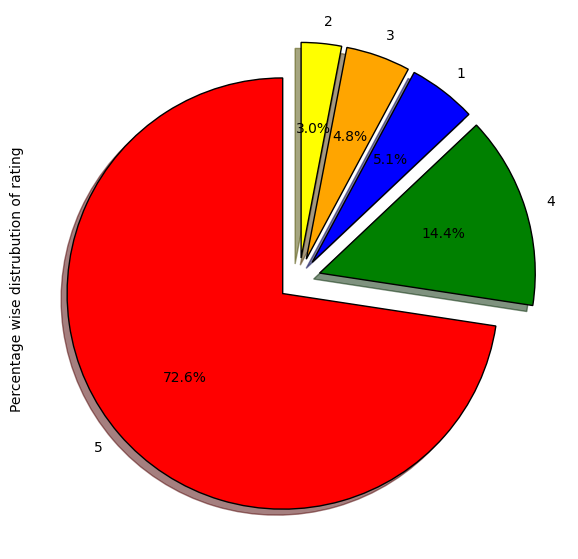

In [20]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [22]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")


Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [23]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [24]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


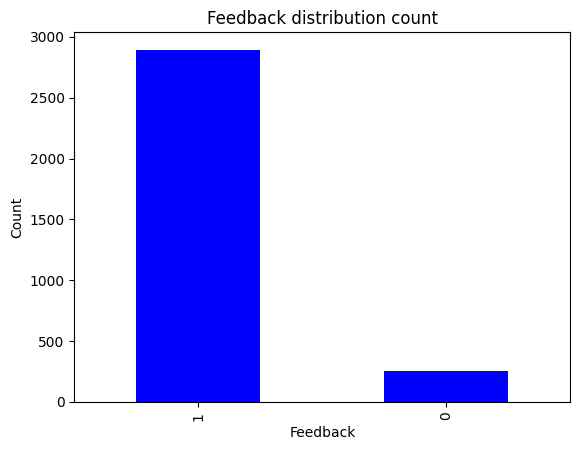

In [25]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [26]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

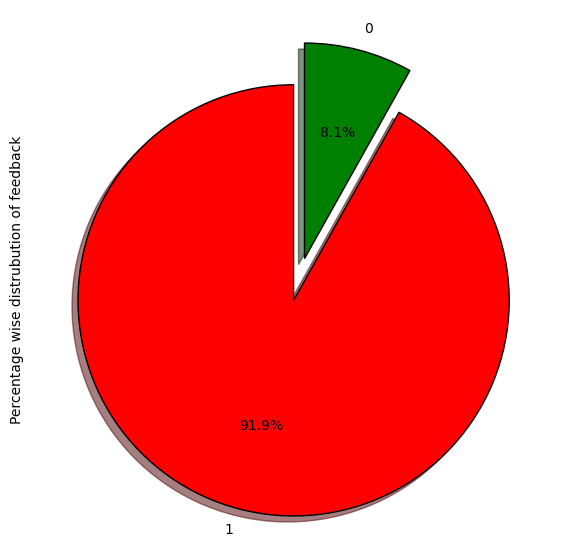

In [27]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [28]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [29]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [30]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


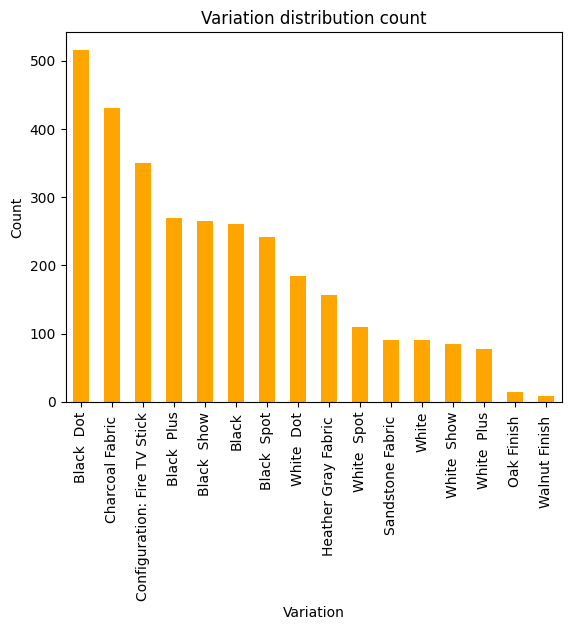

In [31]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [32]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [33]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

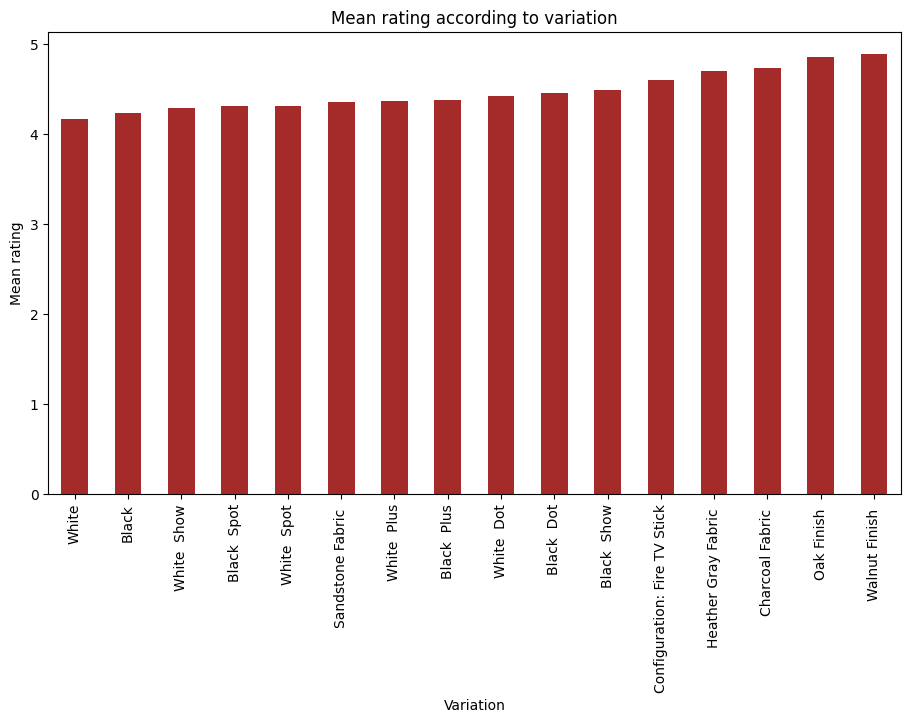

In [34]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [35]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

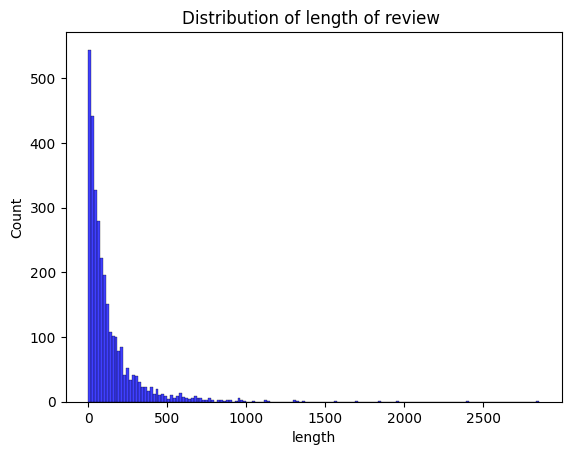

In [36]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

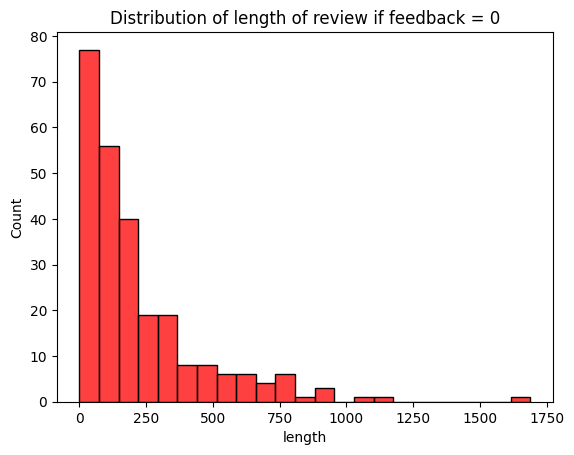

In [37]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

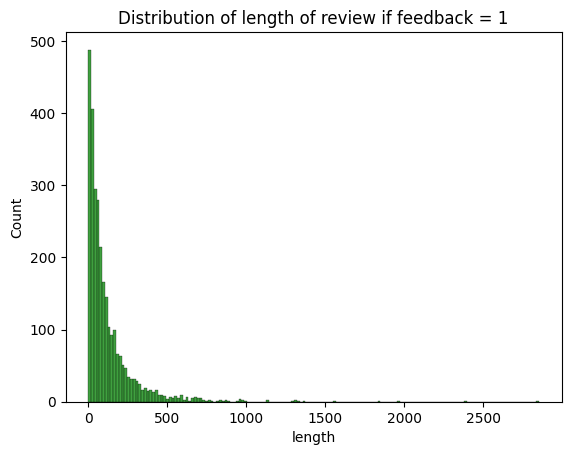

In [38]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

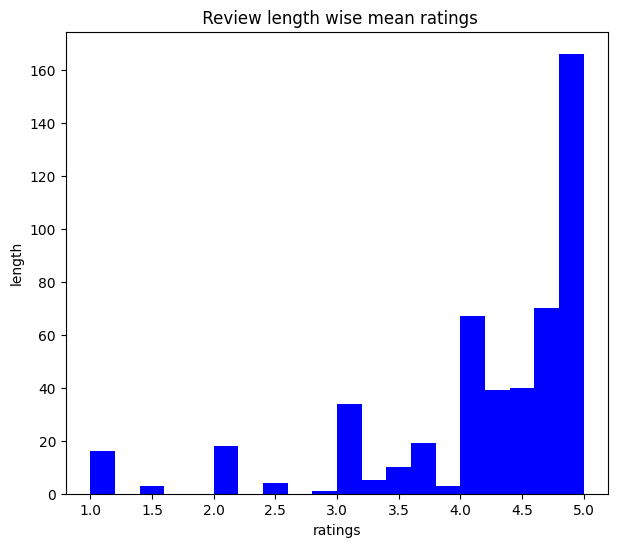

In [39]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [40]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

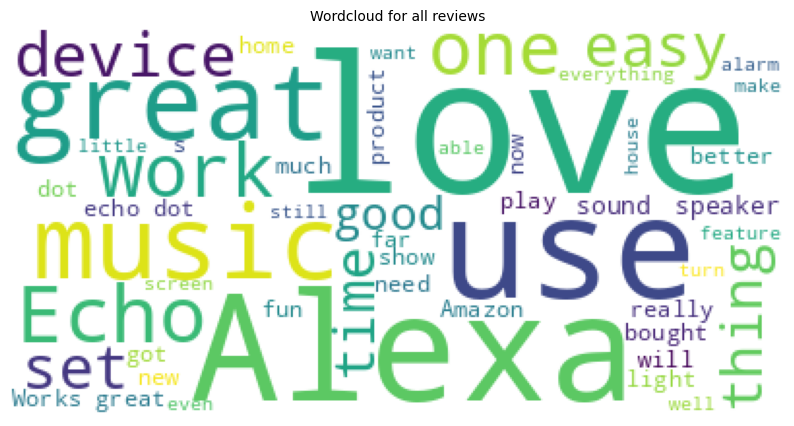

In [41]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [42]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

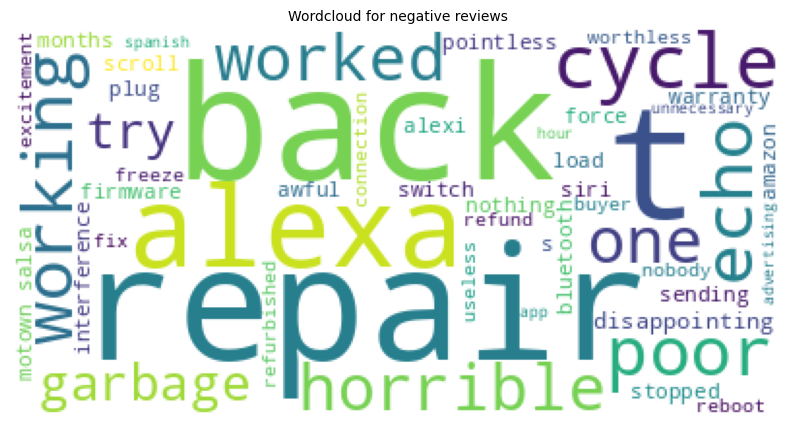

In [43]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()


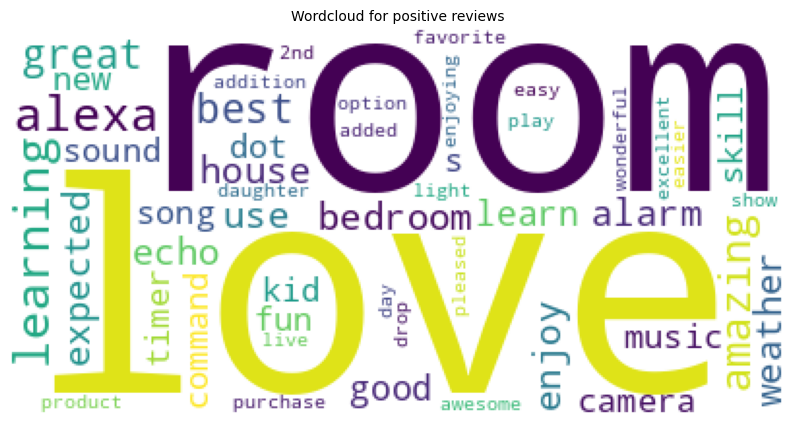

In [44]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()